# **5장. 시계열 데이터와 자연어 처리**  

## **5-2절. 임베딩과   문자 시계열 모델**




### 투수의 구종 순서(피치 시퀀스) 결정을 사용하여, 모델을 만들어 봅시다
류현진의 놀라운 볼 배합 능력을 살펴봅시다.

https://www.youtube.com/watch?v=lHr05zkILCg

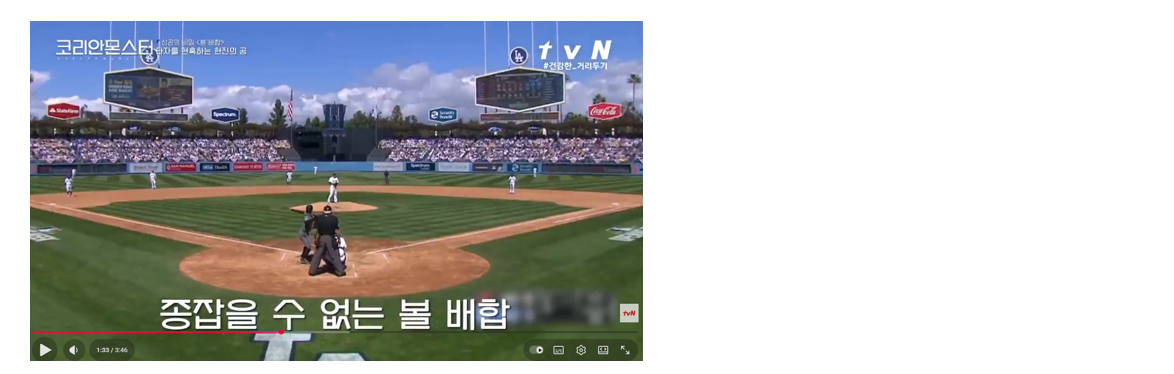

📌[실습 05-13] 라이브러리 불러오기

In [ ]:
!pip install koreanize_matplotlib
import koreanize_matplotlib

import numpy as np; import pandas as pd; import seaborn as sns
import matplotlib.pyplot as plt; import random
import tensorflow as tf; from tensorflow import keras
from keras.models import Sequential; from keras.layers import Embedding, Dense, GRU
from sklearn.metrics import mean_squared_error, r2_score; import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.8 MB/s eta 0:00:00


📌[실습 05-14] 데이터 불러오기

In [ ]:
df=pd.read_csv("구종순서.csv", encoding="cp949")
df.head()

,seq_id,length,pitch_1,pitch_2,pitch_3,pitch_4,pitch_5,pitch_6,pitch_7,pitch_8,pitch_9,pitch_10
0,1,4,직구,슬라이더,체인지업,직구,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,슬라이더,커브,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,9,체인지업,체인지업,슬라이더,슬라이더,체인지업,체인지업,슬라이더,직구,체인지업,NaN
3,4,6,슬라이더,커브,체인지업,슬라이더,직구,체인지업,NaN,NaN,NaN,NaN
4,5,10,직구,슬라이더,커브,직구,직구,슬라이더,커브,직구,슬라이더,커브


###인코딩

📌[실습 05-15] 토크나이저 사용을 위한 데이터 처리하기

In [ ]:
pitch_cols=df.columns[2:]
print("모델에 사용될 열 이름==> ")
print(pitch_cols); print()
data=np.array(df[pitch_cols])   # pitch_1 부터 pitch_10까지만 사용
data=np.where(pd.isna(data), '', data) # NaN을 공백('')으로 처리
print("결측치를 공백으로 바꿈 ==> ")
print(data[:5]); print()
print("각 행의 요소를 공백으로 연결 ==>")
input=[' '.join(row[row != '']) for row in data]
input[:5]

모델에 사용될 열 이름==> 
Index(['pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6',
       'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10'],
      dtype='object')

결측치를 공백으로 바꿈 ==> 
[['직구' '슬라이더' '체인지업' '직구' '' '' '' '' '' '']
 ['슬라이더' '커브' '' '' '' '' '' '' '' '']
 ['체인지업' '체인지업' '슬라이더' '슬라이더' '체인지업' '체인지업' '슬라이더' '직구' '체인지업' '']
 ['슬라이더' '커브' '체인지업' '슬라이더' '직구' '체인지업' '' '' '' '']
 ['직구' '슬라이더' '커브' '직구' '직구' '슬라이더' '커브' '직구' '슬라이더' '커브']]

각 행의 요소를 공백으로 연결 ==>


['직구 슬라이더 체인지업 직구',
 '슬라이더 커브',
 '체인지업 체인지업 슬라이더 슬라이더 체인지업 체인지업 슬라이더 직구 체인지업',
 '슬라이더 커브 체인지업 슬라이더 직구 체인지업',
 '직구 슬라이더 커브 직구 직구 슬라이더 커브 직구 슬라이더 커브']

📌[실습 05-16] 토크나이저 인코딩하기(문자를 숫자로 변환)

In [ ]:
tok=Tokenizer()  # 토크나이저 객체 생성
tok.fit_on_texts(input) # 데이터의 고유한 문자 클래스를 찾아서 정수로 변환

seq_encoded=tok.texts_to_sequences(input)
print("인코딩된 시계열");
print(seq_encoded[:3]);print()

print("문자 --> 인코딩 딕셔너리 확인")
tok.word_index

인코딩된 시계열
[[1, 3, 4, 1], [3, 2], [4, 4, 3, 3, 4, 4, 3, 1, 4]]

문자 --> 인코딩 딕셔너리 확인


{'직구': 1, '커브': 2, '슬라이더': 3, '체인지업': 4}

📌[실습 05-17] 슬라이딩 윈도우 방식으로 피처와 타깃 생성하기

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
lag=3

def create_sliding_window(sequences, window): #슬라이딩 윈도우 함수 정의
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):        # i는 1부터 10까지 이동 (처음 구종은 제외)
            x_seq = seq[max(0, i-window):i] # i 이전의 시차만큼의 구종 (피처)
            y_seq = seq[i]                  # i번째 구종 (타깃)
            # 패딩
            if len(x_seq) < lag:   # 패딩 조건 확인
                x_seq = np.pad(x_seq, (lag - len(x_seq), 0)) # 부족한 앞쪽을 0으로 채움
            X.append(x_seq); y.append(y_seq)
    return np.array(X), np.array(y)

X, y = create_sliding_window(seq_encoded, lag)  # 함수 호출
print(f"피처: shape={X.shape}"); print(X); print()
print(f"타깃: shape={y.shape}"); print(y)
print(y)

피처: shape=(4439, 3)
[[0 0 1]
 [0 1 3]
 [1 3 4]
 ...
 [0 0 2]
 [0 0 2]
 [0 2 2]]

타깃: shape=(4439,)
[3 4 1 ... 4 2 1]
[3 4 1 ... 4 2 1]


📌[실습 05-18] 문자 시계열 모델의 구조 확인하기  

In [ ]:
#시드 고정과 데이터 분할
SEED=42; np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=SEED )

class_size=len(tok.word_index) + 1  # 구종 수 + 1 (0은 패딩)
print("클래스 수(패딩 포함)=", class_size)
print(f"입력 시퀀스 다음에 {class_size } 개의 클래스가 나타날 확률을 예측하는 분류 문제가 됩니다" )


클래스 수(패딩 포함)= 5
입력 시퀀스 다음에 5 개의 클래스가 나타날 확률을 예측하는 분류 문제가 됩니다


📌[실습 05-19] GRU 기반 문자 시계열 예측 모델 설정하기  

In [ ]:
embedding_dim=2   # 임베딩 벡터의 차원 지정

model=Sequential()
model.add(Embedding(input_dim=class_size, output_dim=embedding_dim))
model.add(GRU(32, input_shape=(lag,1)))
#model.add(Dense(8, activation='relu')) # 은닉층 추가 가능
model.add(Dense(class_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

📌[실습 05-20] GRU 기반 문자 시계열 예측 모델 학습하기

In [ ]:
early_stop=EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)

history=model.fit(x_train, y_train, validation_data=(x_test, y_test),
    epochs=200, callbacks=[early_stop] )

📌[실습 05-21] 학습 과정에서의 손실과 예측 정확도 변화 시각화하기  

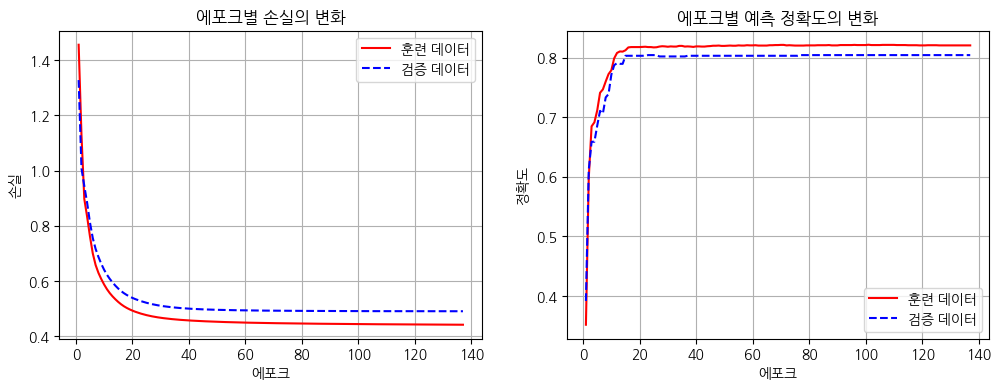

In [ ]:
# 학습 과정 시각화(손실, 예측 정확도)
epochs=range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 4))

# 1. 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'r-', label='훈련 데이터')
plt.plot(epochs, history.history['val_loss'], 'b--', label='검증 데이터')
plt.title('에포크별 손실의 변화')
plt.xlabel('에포크'); plt.ylabel('손실')
plt.legend(); plt.grid(True)

# 2. 예측 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'r-', label='훈련 데이터')
plt.plot(epochs, history.history['val_accuracy'],'b--', label='검증 데이터')
plt.title('에포크별 예측 정확도의 변화')
plt.xlabel('에포크'); plt.ylabel('정확도')
plt.legend(); plt.grid(True)
plt.show()

그렇다면 이제 학습 성과가 0.88 정도 나오도록 패턴+노이즈가 적절히 섞인 데이터를 만들었고, 독자에게 설명할 때:

현재 GRU 모델은 시퀀스 패턴만으로 학습했기 때문에 어느 정도 정확도(0.88)까지 올라감

더 높은 정확도(예: 0.95 이상)를 얻으려면 추가 피처가 필요함

예: 투수별 특성, 투구 속도, 경기 상황 등

이렇게 하면 모델이 단순 구종 패턴뿐만 아니라 상황별 의사결정 패턴까지 학습 가능

즉, 교재나 실습에서는:

"지금은 구종 시퀀스 패턴만으로 모델을 학습했기 때문에 train/val 정확도가 약 0.88 정도입니다. 실제 정확도를 더 높이려면 구종 외의 투수 특성, 구속, 스트라이크존 위치 등 추가 피처가 필요합니다."

📌[실습 05-22] 학습된 모델의 예측정확도 시각화하기

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


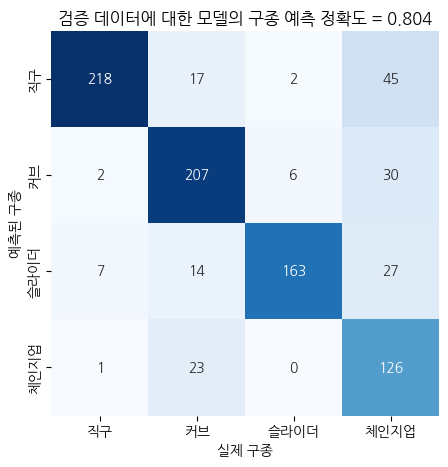

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
# 검증용 데이터에 대한 모델 예측 생성
y_probs=model.predict(x_test)    # 확률 예측
y_pred=np.argmax(y_probs, axis=1) # 확률이 가장 큰 클래스 선택

class_labels=["직구", "커브", "슬라이더", "체인지업"]
cm=confusion_matrix(y_test, y_pred) # 혼동행렬 생성
acc=accuracy_score(y_test, y_pred) # 분류정확도 계산

# 혼동 행렬 시각화 (이전과 동일)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', cbar=None,
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('실제 구종'); plt.ylabel('예측된 구종')
plt.title(f'검증 데이터에 대한 모델의 구종 예측 정확도 = {acc:.3f}')
plt.show()


📌[실습 05-23] 새로운 피처에 대한 다음 구종 예측하기

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
클래스별 확률(패딩포함)= [0.    0.019 0.013 0.954 0.014]


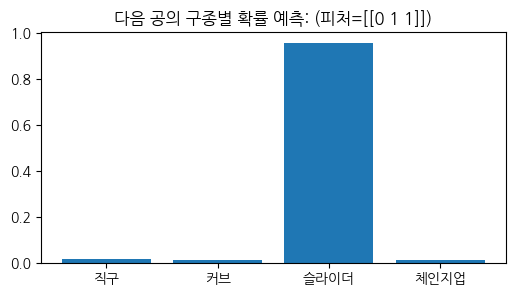

In [ ]:
# 새 피처 (패딩 포함)
x_new=np.array([0,1,1]).reshape(1,3)  # 패딩 ->  직구 ->  직구

# 모델 예측
probs=model.predict(x_new)[0]
print("클래스별 확률(패딩포함)=", np.round(probs,3))

# 확률 그래프
구종_인코딩=['직구', '커브', '슬라이더', '체인지업']  # 데이터에 출현하는 순서로 배열됨
plt.figure(figsize=(6, 3))
plt.bar(구종_인코딩, probs[1:]) # 패딩 제외
plt.title(f"다음 공의 구종별 확률 예측: (피처={x_new})")
plt.show()

📌피처 변경

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
클래스별 확률(패딩포함)= [0.    0.003 0.945 0.001 0.051]


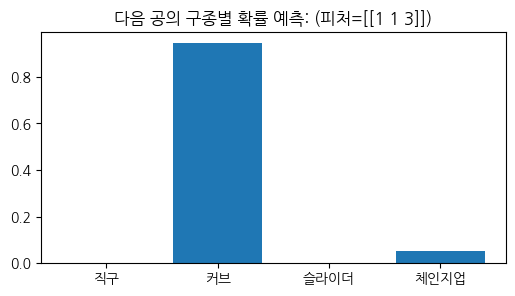

In [ ]:
x_new=np.array([1,1,3]).reshape(1,3) # 직구 -> 직구 -> 슬라이드

# 모델 예측
probs=model.predict(x_new)[0]
print("클래스별 확률(패딩포함)=", np.round(probs,3))

# 확률 그래프
plt.figure(figsize=(6, 3))
plt.bar(구종_인코딩, probs[1:])
plt.title(f"다음 공의 구종별 확률 예측: (피처={x_new})")
plt.show()

📌[실습 05-24] 최적화된 임베딩 벡터 시각화하기

직구: [-1.2979848  1.3351322]
커브: [0.6309566 1.3688426]
슬라이더: [ 1.0781817 -0.6611999]
체인지업: [-0.75998193 -0.97605306]


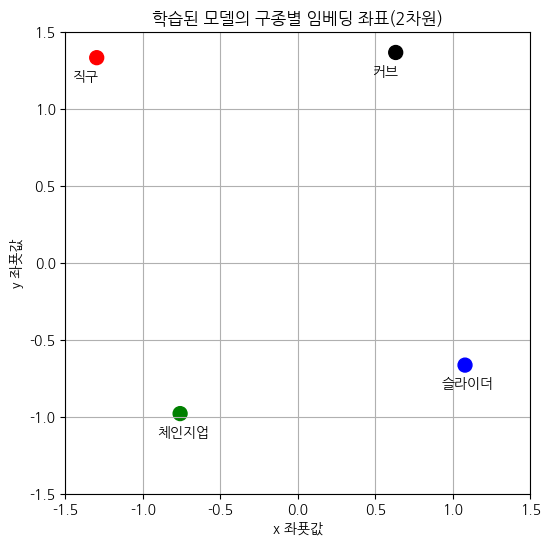

In [ ]:
# 1. 임베딩 벡터 추출
embedding_layer=model.layers[0]      # 첫 번째 Embedding 층
embedding_weights=embedding_layer.get_weights()[0]

# 2. 구종별 벡터 출력
for i in range(1, 5):                # 0=패딩 제외
    word=[k for k, v in tok.word_index.items() if v == i][0]
    vector=embedding_weights[i]
    print(f"{word}: {vector}")

# 3. 그래프 그리기
words=[k for k, v in sorted(tok.word_index.items(), key=lambda x: x[1]) if v != 0] # 패딩 제외
vectors=embedding_weights[1:len(words)+1]
x=vectors[:, 0]; y = vectors[:, 1] # x축과 y축 좌표값 계산

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=100, color=['r', 'k', 'b', 'g'])  # 색상 지정

# 4. 각 점 위에 구종 이름 표시
for i, word in enumerate(words):
    plt.text(x[i]-0.15, y[i]-0.15, word, fontsize=10)  # 이름 위치 설정

plt.title("학습된 모델의 구종별 임베딩 좌표(2차원)", fontsize=12)
plt.xlabel("x 좌푯값"); plt.ylabel("y 좌푯값")
plt.grid()
plt.ylim(-1.5, 1.5); plt.xlim(-1.5, 1.5)  # 축의 범위 조정
plt.show()
